# BAP1 cis comparison


BAP1 is known as a tumor suppressor and a deubiquitinase. "The presence of ubiquitin molecules on a protein can affect the activity of the protein and its interactions with other proteins. The ubiquitin "tag" also promotes breakdown (degradation) of a protein. By removing ubiquitin, BAP1 helps regulate the function of many proteins involved in diverse cellular processes. The BAP1 protein is thought to help control cell growth and division (proliferation) and cell death" (https://ghr.nlm.nih.gov/gene/BAP1).

## Step 1: Library Imports

Run this cell to import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re
import sys 
sys.path.append('C:\\Users\\brittany henderson\\GitHub\\WhenMutationsMatter\\Brittany\\')
import functions as f

import cptac
import cptac.algorithms as al

In [2]:
def add_to_all_results(df, gene, omics, comparison, all_comp):
    expanded = df
    expanded['Gene'] = gene
    expanded['Comparison'] = comparison
    expanded['Omics'] = omics
    
    updated_all_comparisons = pd.concat([all_comp, expanded], sort=False)
    
    return updated_all_comparisons

In [64]:
# Create boxplot and stripplot with pval annotation
def cis_plot(df, gene, omics_name, pval, mutation_type="Mutated"):
    omics_col = gene+"_"+omics_name
    
    # get right order for boxplots
    if mutation_type == "Mutated":
        comparison_list = ['Wildtype', 'Mutated']
    elif mutation_type == "Missense":
        comparison_list = ['Wildtype', 'Missense']
    elif mutation_type == "Truncation":
        comparison_list = ['Wildtype', 'Truncation']
        
    # get pval from dataframe or float 
    if isinstance(pval, pd.DataFrame):
        pval_series = pval['P_Value']
        num_pval = float(pval_series[0])
        str_pval = str(pval_series[0])
    elif isinstance(pval, float):
        num_pval = pval
        str_pval = str(pval)
        
    # Boxplot and Stripplot
    plt.rcParams['figure.figsize']=(8,5)
    sns.set(font_scale = 1.3)
    cis_boxplot = sns.boxplot(data = df, x = 'binary_mutations',
                              y = omics_col, order = comparison_list, showfliers = False)  
    cis_boxplot.set_title(
        gene + " Effect on " + gene +" "+omics_name.capitalize()+" in Kidney Tumors\n P-Value = "+str_pval[:6]+"\n")
    cis_boxplot = sns.stripplot(data= df, x = 'binary_mutations',
                                y = omics_col,jitter = True, color = ".3", order = comparison_list)
    cis_boxplot.set(xlabel = "\n"+gene + " Mutation Status in Tumors", ylabel = omics_name.capitalize())
    cis_boxplot.set_xticklabels(cis_boxplot.get_xticklabels())
    
    # pval annotation
    bonferroni_cutoff = .05/6
    if num_pval <= bonferroni_cutoff:
        pval_symbol = "*"
    else:
        pval_symbol = "ns"
    
    x1, x2 = 0, 1   # columns (first column: 0, see plt.xticks())
    y, h = df[omics_col].max() + .05, .05  
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, color= '.3')
    plt.text((x1+x2)*.5,y+h, pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")

    plt.show()
    plt.clf()
    plt.close()

## Step 2: Find the mutation frequency of BAP1 for Kidney Cancer

In [4]:
rc = cptac.RenalCcrcc()
desired_cutoff = 0.1
gene = 'BAP1'

freq_mut = al.get_frequently_mutated(rc, cutoff = desired_cutoff)
freq_mut.loc[freq_mut['Gene'] == gene]

,Gene,Unique_Samples_Mut,Missense_Mut,Truncation_Mut
0,BAP1,0.154545,0.063636,0.090909


## Step 3: cis comparisons for omics 

Determine if the DNA mutation has an effect on the omics measurement. In order to do this, we have a few steps in code. These steps are found in the format_cis_comparison_data function.
1. get a table with both the omics and mutation data for tumors
2. get a binary column from the mutation data to separate our samples
3. format data frame to be used in the T-test
4. send data to the T-test.

The format_cis_comparison_data does the first 3 steps.

# Proteomics cis comparison

Proteomics: Mutated and Wildtype

In [5]:
omics_name = "proteomics"

In [6]:
prot_mut_status = f.format_cis_comparison_data(rc, 'proteomics', gene)

prot_col_list = [gene+'_proteomics']
prot_col = gene+"_proteomics"

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison\n")
prot_results = al.wrap_ttest(prot_mut_status, 'binary_mutations', prot_col_list)

total_tests = len(freq_mut)
all_comparisons = pd.DataFrame(columns=["Gene", "Omics", "Comparison", "P_Value"])
gene='BAP1'
if prot_results is not None:
    # Adjust for multiple hypothesis testing
    pval_results = f.add_significance_col(prot_results, total_tests)
    print(pval_results, '\n')
    # Create dataframe with all results
    all_comparisons = add_to_all_results(pval_results, gene, 'Proteomics', 'mutated/wildtype', all_comparisons)
    

Doing t-test comparison

        Comparison   P_Value  Significant
0  BAP1_proteomics  0.010487        False 



This p-value is not significant because of multiple hypothesis testing. Other notebooks test the rest of the frequently mutated genes. 

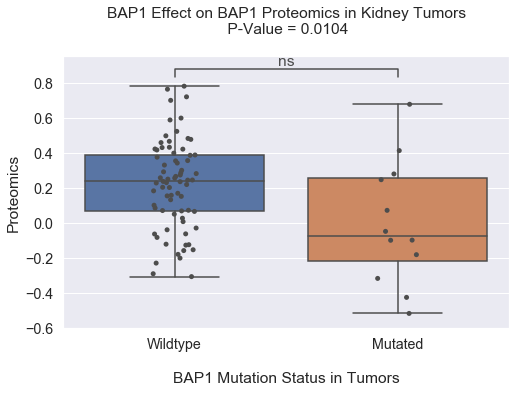

In [7]:
cis_plot(prot_mut_status, gene, "proteomics", pval_results)

Proteomics: Missense and Truncation compared to wildtype

In [8]:
# Create data frame with mutation types and wildtype binary column
prot_mut_type = f.get_missense_truncation_comparison(rc, omics_name, gene)
prot_wildtype = prot_mut_status.loc[
    prot_mut_status['binary_mutations'] == 'Wildtype'] # select all wildtype from binary_mutations
prot_mut_and_wildtype = prot_mut_type.append(prot_wildtype, sort=False) # use for graph

In [65]:
# compare missense and wildtype
prot_miss_wt = prot_mut_and_wildtype.loc[prot_mut_and_wildtype['binary_mutations'] != 'Truncation']
print("Doing t-test comparison for missense and wildtype\n")
prot_results_miss = al.wrap_ttest(prot_miss_wt, 'binary_mutations', prot_col_list, verbose = True)

if prot_results_miss is not None:
    pval_results = f.add_significance_col(prot_results_miss, total_tests) # Adjust for multiple hypothesis testing
    print(pval_results, '\n')
    # Create dataframe with all results
    all_comparisons = add_to_all_results(pval_results, 'Proteomics', 'missense/wildtype', all_comparisons) 

Doing t-test comparison for missense and wildtype

BAP1_proteomics :  0.29301416816985876
No significant comparisons.


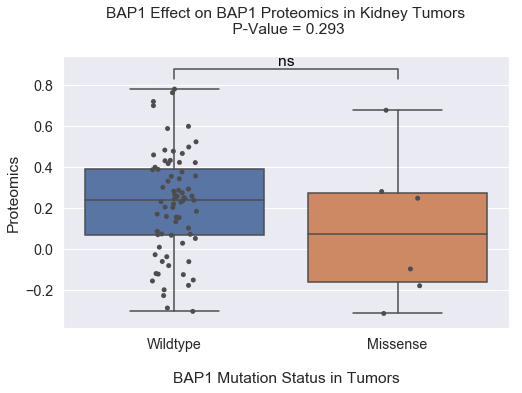

In [66]:
pval_miss = 0.2930
cis_plot(prot_miss_wt, gene, "proteomics", pval_miss, mutation_type= "Missense")

In [67]:
# compare truncation and wildtype
prot_trunc_wt = prot_mut_and_wildtype.loc[prot_mut_and_wildtype['binary_mutations'] != 'Missense']
print("\n\nDoing t-test comparison for truncation and wildtype\n")
prot_results_trunc = al.wrap_ttest(prot_trunc_wt, 'binary_mutations', prot_col_list)

if prot_results_trunc is not None:
    pval_trunc_results = f.add_significance_col(prot_results_trunc, total_tests)#adjust multiple hypothesis testing
    print(pval_trunc, '\n')
    all_comparisons = add_to_all_results(pval_trunc_results, gene, omics_name, 'truncation/wildtype', all_comparisons) 



Doing t-test comparison for truncation and wildtype

0.004735714537128461 



In [29]:
pval_series = pval_trunc['P_Value']
pval_trunc = float(pval_series[0])


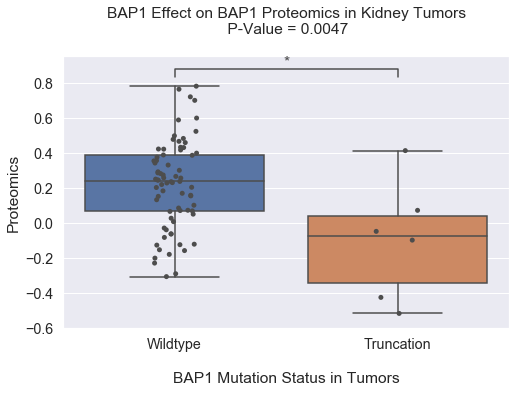

In [34]:
cis_plot(prot_trunc_wt, gene, "proteomics", pval_trunc, "Truncation")

In [47]:
pval_list = [pval_miss, pval_trunc]


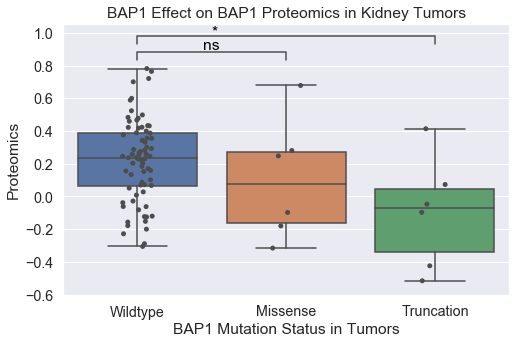

In [48]:
# Plots with all data for Tumor Samples
plt.rcParams['figure.figsize']=(8,5)
sns.set(font_scale = 1.3)
trans_cis_boxplot = sns.boxplot(data = prot_mut_and_wildtype, x = 'binary_mutations',
                          y = prot_col, order = ["Wildtype","Missense","Truncation"], showfliers = False)  
trans_cis_boxplot.set_title(gene + " Effect on " + gene +" Proteomics in Kidney Tumors")
trans_cis_boxplot = sns.stripplot(data = prot_mut_and_wildtype, x = 'binary_mutations',y = prot_col, jitter = True, 
                        color = ".3", order = ["Wildtype","Missense","Truncation"])
trans_cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")

# pval annotation
bonferroni_cutoff = .05/6
for pval in pval_list:
    if pval <= bonferroni_cutoff:
        pval_symbol = "*"
    else:
        pval_symbol = "ns"


#pval annotations for missense
x1, x2 = 0, 1 # columns (first column: 0, see plt.xticks())
y, h = prot_mut_and_wildtype[gene+"_proteomics"].max() + .05, .05  
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, color= '.3')
plt.text((x1+x2)*.5,y+h, "ns", horizontalalignment='center', verticalalignment='bottom', color = "black")

#pval annotations for truncation
x3, x4 = 0, 2 # columns (first column: 0, see plt.xticks())
y, h = prot_mut_and_wildtype[gene+"_proteomics"].max() + .15, .05  
plt.plot([x3, x3, x4, x4], [y, y+h, y+h, y], lw=1.5, color= '.3')
plt.text((x1+x2)*.5,y+h, pval_symbol, ma = "center", color = "black")

plt.show()
plt.clf()
plt.close()

# Transcriptomics cis comparison

Transcriptomics: Mutated and Wildtype

In [49]:
omics_name_2 = 'transcriptomics'
trans_mut_status = f.format_cis_comparison_data(rc, 'transcriptomics', gene)

trans_col_list = [gene+'_transcriptomics']

print("Doing t-test comparison for mutation status\n")
transcrpt_results = al.wrap_ttest(trans_mut_status, 'binary_mutations', trans_col_list)

if transcrpt_results is not None:
    # Adjust for multiple hypothesis testing
    pval_results = f.add_significance_col(transcrpt_results, total_tests)
    print(pval_results, '\n')
    # Create dataframe with all results
    all_comparisons = add_to_all_results(pval_results, gene, 'Transcriptomics', 'mutated/wildtype', all_comparisons)


Doing t-test comparison for mutation status

             Comparison   P_Value  Significant
0  BAP1_transcriptomics  0.010493        False 



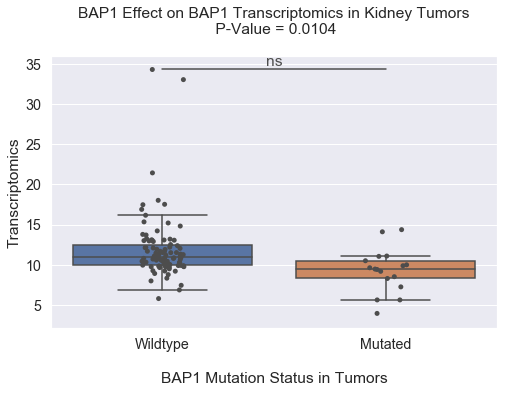

In [50]:
cis_plot(trans_mut_status, gene, omics_name_2, pval_results)

Transcriptomics: Missense and Truncation

In [61]:
# select all wildtype from earlier -add to mut_type binary column
trans_wildtype = trans_mut_status.loc[trans_mut_status['binary_mutations'] == 'Wildtype'] 
trans_mut_type = f.get_missense_truncation_comparison(rc, 'transcriptomics', gene)
trans_mut_and_wildtype = trans_mut_type.append(trans_wildtype, sort=False) # use for all data graph

In [62]:
trans_col_list = [gene+'_transcriptomics']
# compare missense and wildtype
miss_wt = trans_mut_and_wildtype.loc[trans_mut_and_wildtype['binary_mutations'] != 'Truncation']
print("Doing t-test comparison for missense and wildtype\n")
transcrpt_results_miss = al.wrap_ttest(miss_wt, 'binary_mutations', trans_col_list, verbose = True)

if transcrpt_results_miss is not None:
    pval_results = f.add_significance_col(transcrpt_results_miss, total_tests)# Adjust for multiple hypothesis testing
    print(pval_results, '\n')
    all_comparisons = add_to_all_results(pval_results, 'Transcriptomics', 'missense/wildtype', all_comparisons)

Doing t-test comparison for missense and wildtype

BAP1_transcriptomics :  0.14715956649931367
No significant comparisons.


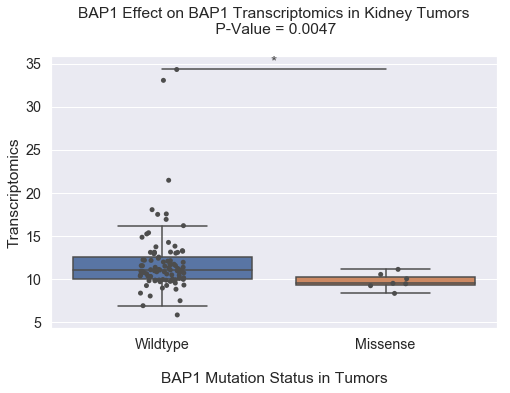

In [63]:
trans_pval_miss = 0.1471
cis_plot(miss_wt, gene, "transcriptomics", pval, mutation_type= "Missense")

In [55]:
# compare truncation and wildtype
trunc_wt = trans_mut_and_wildtype.loc[trans_mut_and_wildtype['binary_mutations'] != 'Missense']
print("\n\nDoing t-test comparison for truncation and wildtype\n")
transcrpt_results_trunc = al.wrap_ttest(trunc_wt, 'binary_mutations', trans_col_list)

if transcrpt_results_trunc is not None:
    pval_results = f.add_significance_col(
        transcrpt_results_trunc, total_tests) # Adjust for multiple hypothesis testing
    print(pval_results, '\n')
    all_comparisons = add_to_all_results(pval_results, gene, 'Transcriptomics', 'truncation/wildtype', all_comparisons)



Doing t-test comparison for truncation and wildtype

             Comparison   P_Value  Significant
0  BAP1_transcriptomics  0.028673        False 



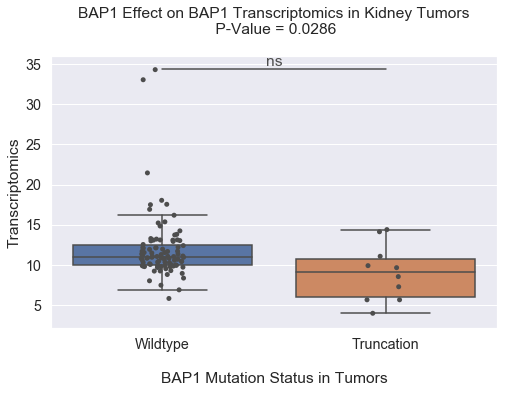

In [56]:
cis_plot(trunc_wt, gene, "transcriptomics", pval_results, mutation_type= "Truncation")

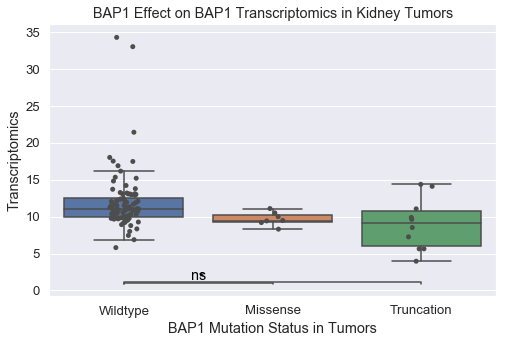

In [60]:
trans_col = gene+"_transcriptomics"
trans_pval_list = [trans_pval_miss, trans_pval_trunc]
plt.rcParams['figure.figsize']=(8,5)
sns.set(font_scale = 1.2)
trans_cis_boxplot = sns.boxplot(data = trans_mut_and_wildtype, x = 'binary_mutations',
                          y = trans_col, order = ["Wildtype","Missense","Truncation"], showfliers = False)  
trans_cis_boxplot.set_title(gene + " Effect on " + gene +" Transcriptomics in Kidney Tumors")
trans_cis_boxplot = sns.stripplot(data = trans_mut_and_wildtype, x = 'binary_mutations',y = trans_col, jitter = True, 
                        color = ".3", order = ["Wildtype","Missense","Truncation"])
trans_cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Transcriptomics")

# pval annotation
bonferroni_cutoff = .05/6
for pval in pval_list:
    if pval <= bonferroni_cutoff:
        pval_symbol = "*"
    else:
        pval_symbol = "ns"


#pval annotations for missense
x1, x2 = 0, 1 # columns (first column: 0, see plt.xticks())
y, h = prot_mut_and_wildtype[gene+"_proteomics"].max() + .05, .15  
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, color= '.3')
plt.text((x1+x2)*.5,y+h, "ns", horizontalalignment='center', verticalalignment='bottom', color = "black")

#pval annotations for truncation
x3, x4 = 0, 2 # columns (first column: 0, see plt.xticks())
y, h = prot_mut_and_wildtype[gene+"_proteomics"].max() + .15, .15  
plt.plot([x3, x3, x4, x4], [y, y+h, y+h, y], lw=1.5, color= '.3')
plt.text((x1+x2)*.5,y+h, pval_symbol, ma = "center", color = "black")

plt.show()
plt.clf()
plt.close()

# Phosphoproteomics cis comparison

Phosphoproteomics: Mutated and Wildtype

In [ ]:
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest
omics_and_mut = rc.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'phosphoproteomics', omics_genes = gene)

# Step 2 - Create the binary column needed to do the comparison
omics_and_mut['binary_mutations'] = omics_and_mut[gene+'_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else 'Mutated')

# Step 3 - Format
omics_and_mut = omics_and_mut.query('Sample_Status != "Normal"') # changed because warning with slice
#tumors = omics_and_mut.loc[omics_and_mut['Sample_Status'] == 'Tumor'] #drop Normal samples
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
binary_phospho = omics_and_mut.drop(columns_to_drop, axis = 1)
only_phospho = binary_phospho.drop('binary_mutations', axis = 1)
binary_phospho['binary_mutations'].value_counts()
binary_phospho[['BAP1-S292_phosphoproteomics','binary_mutations']].dropna(axis=0)
binary_phospho
# 2 col BAP1-S325_phosphoproteomics

In [ ]:
phos_col_list = list(only_phospho.columns)

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutation status\n")
phos_pval_results = wrap_ttest(binary_phospho, 'binary_mutations', phos_col_list)
phos_pval_results

Graph

In [ ]:
# Create data frame with all significant phospho sites in order to graph
phospho_list = list(only_phospho.columns)
phospho_df = pd.melt(binary_phospho, id_vars = 'binary_mutations', 
            value_vars = phospho_list, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phospho_df.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names
#sig_phospho_df.dropna(axis=0)

In [ ]:
plt.rcParams['figure.figsize']=(25,15) #size of plot
sns.set(font_scale = 2)
cis_boxplot = sns.boxplot(data = phospho_df, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                             hue_order = ["Wildtype","Mutated"], showfliers = False)  
cis_boxplot.set_title(gene + " Effect on " + gene + " Phosphoproteomics in Ovarian Tumors")
cis_boxplot = sns.stripplot(data = phospho_df, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                               hue_order = ["Wildtype","Mutated"], jitter = True, color = ".3", dodge = True)
cis_boxplot.set(xlabel = 'Phosphorylation Sites', ylabel = "Phosphorylation Levels")
cis_boxplot.set_xticklabels(cis_boxplot.get_xticklabels(),rotation = 70)
plt.show()
plt.clf()
plt.close()

Phosphoproteomics: Missense and Truncation

In [ ]:
# select all wildtype from earlier -add to mut_type binary column
phos_wildtype = binary_phospho.loc[binary_phospho['binary_mutations'] == 'Wildtype'] 

phos_mut_type = f.get_missense_truncation_comparison(rc, 'phosphoproteomics', gene)
phos_mut_and_wildtype = phos_mut_type.append(phos_wildtype, sort=True) 

In [ ]:
phos_col_list = list(only_phospho.columns)
# compare missense and wildtype
miss_wt = phos_mut_and_wildtype.loc[phos_mut_and_wildtype['binary_mutations'] != 'Truncation']
print("Doing t-test comparison for missense and wildtype\n")
phos_results_miss = al.wrap_ttest(miss_wt, 'binary_mutations', phos_col_list)
print(phos_results_miss)

# compare truncation and wildtype 
trunc_wt = phos_mut_and_wildtype.loc[phos_mut_and_wildtype['binary_mutations'] != 'Missense']
print("\n\nDoing t-test comparison for truncation and wildtype\n")
phos_results_trunc = al.wrap_ttest(trunc_wt, 'binary_mutations', phos_col_list)
print(phos_results_trunc)

Graph Missense and Truncation

In [ ]:
# Create data frame with all significant phospho sites in order to graph
phos_mut_type_df = pd.melt(phos_mut_and_wildtype, id_vars = 'binary_mutations', 
            value_vars = phos_col_list, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phos_mut_type_df.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names
#sig_phospho_df.dropna(axis=0)

In [ ]:
plt.rcParams['figure.figsize']=(25,15) #size of plot
sns.set(font_scale = 2)
phos_cis_boxplot = sns.boxplot(data = phos_mut_type_df, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                             hue_order = ["Wildtype","Missense","Truncation"], showfliers = False)  
phos_cis_boxplot.set_title(gene + " Effect on " + gene + " Phosphoproteomics in Ovarian Tumors")
phos_cis_boxplot = sns.stripplot(data = phos_mut_type_df, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                               hue_order = ["Wildtype","Missense","Truncation"], jitter = True, color = ".3", dodge = True)
phos_cis_boxplot.set(xlabel = 'Phosphorylation Sites', ylabel = "Phosphorylation Levels")
phos_cis_boxplot.set_xticklabels(phos_cis_boxplot.get_xticklabels(),rotation = 70)
plt.show()
plt.clf()
plt.close()

#  Compare common mutations

Find the common mutation types and compare them to the wildtype tumors.

In [ ]:
# Count all mutations (including all mutations in a sample)
somatic_mutations = ov.get_mutations()
gene_mutations = somatic_mutations.loc[somatic_mutations['Gene'] == gene]
count_all_mut = gene_mutations['Mutation'].value_counts()
count_all_mut


In [ ]:
mut = 'Missense_Mutation'
gene_mutations.loc[gene_mutations['Mutation'] == mut]
#gene_mutations['Location'].value_counts()

# Analysis of Results

No significant cis comparisons. Almost all mutations are missense mutations. Five of the ten missense are found in the UBC domain associated with ubiquitination (~3000-4000). (NIH)

No acetylproteomics for the ovarian dataset.

In [ ]:
all_results = {"Mutated vs Wildtype": prot_pval_results}
r = pd.DataFrame.from_dict(all_results)